In [22]:
!python SyncNet.py

^C


In [10]:
import scipy.io
import numpy as np

# Load the .mat file
mat = scipy.io.loadmat('toy.mat')
train_data = mat['train']
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'labtest', 'labtrain', 'labval', 'test', 'train', 'val'])


In [14]:
train_data = mat['train'][0][0]

In [23]:
np.mean(np.abs(train_data))

np.float64(1.073838586806137)

In [17]:
oca_data = oca_mat['X'][0]

In [27]:
np.mean(np.abs(oca_data * scale))

np.float64(1.0738385868061369)

In [8]:
scale = 1.073838586806137 / 4.926157948511734e-06

In [26]:
scale

217987.0393986372

In [16]:
oca_mat = scipy.io.loadmat('OCA_data.mat')
oca_mat['X'] # shape: 59, 8008
print(oca_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X'])


In [21]:
print(oca_mat['X'].shape)

(59, 8008)


In [ ]:
print(type(mat['train']))
print(mat['train'].shape)

<class 'numpy.ndarray'>
(8400, 8, 50)


In [ ]:
# Check a variable's content
print(np.array(mat['val']))
print(mat['val'].shape) 

[[[ 1.8899287   0.60511861 -1.50906933 ... -1.78272763 -0.53679139
    1.50029877]
  [ 0.2151087   0.08161576 -0.00595021 ... -0.68884155 -0.89950455
    0.85801338]
  [ 2.04060564 -0.64354525 -1.7708742  ...  1.5945324   0.42111625
   -0.97835585]
  ...
  [-1.7769441  -0.82470318  1.20800188 ...  2.35298427 -0.14699269
   -1.69063884]
  [-1.07277551 -0.68256032  0.40587871 ... -0.71282311 -0.94444765
    0.9128213 ]
  [ 0.61190282  0.12766607 -0.13516619 ...  2.1244577   1.45977794
   -0.77233055]]

 [[-1.09512735 -1.06712539  1.58085053 ... -1.7323379  -0.25621302
    1.4109829 ]
  [-0.81893581  0.02966408  2.28167931 ... -0.9686246   0.35013887
    1.27088301]
  [ 0.08617045 -0.09664296  0.71137892 ...  1.2806929  -1.01783775
   -1.33633679]
  ...
  [ 0.15712177  0.28523152  0.16530902 ... -0.51414953 -1.90930936
   -0.54879981]
  [-0.75843511 -1.71192513 -0.62261457 ... -0.20450377 -1.07821957
   -1.82965014]
  [ 1.17046562 -2.46975327 -2.62058158 ...  2.27747707 -1.38492816
   -2.

In [ ]:
# Check a variable's content
print(np.array(mat['test']))
print(mat['test'].shape) 

[[[-0.54736832  0.45684721  0.08562615 ... -0.91572772 -1.23358407
    0.62779867]
  [ 3.44318242  0.81713322 -2.30014448 ... -0.35873633  0.37929078
    0.42016319]
  [ 4.57446242  2.90355689 -1.58776038 ... -1.15705555 -1.0009557
    0.04322679]
  ...
  [-2.6600594  -0.53434762  1.06774174 ...  0.79439704  0.35349451
   -1.04897155]
  [-0.53760028 -2.91440263 -1.41320146 ...  1.03750045  1.80405165
   -0.42156915]
  [-0.84104198 -3.83850266 -1.64431972 ... -1.41753239  2.6564423
    2.62039738]]

 [[-0.64646835  0.15979698  0.62552734 ...  0.09576382  0.94190243
    0.75323174]
  [ 3.14745104  0.63178059 -1.81827737 ...  0.26060919 -2.30009433
   -1.68969679]
  [ 0.85794851  2.25398201  0.89133947 ...  0.40782396 -0.69983257
   -0.65820283]
  ...
  [-1.1767596   0.786442    1.25306746 ... -0.18690217  2.42442731
    2.24099378]
  [-1.58097892 -0.99166652  1.57067323 ... -2.48247532  1.5674848
    3.77765951]
  [-0.78359503 -2.7074972  -1.71037918 ... -2.26404659 -2.8820695
    1.8168

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # Use TF1.x graph mode in TF2.x
import numpy as np
import utils  # Must have channel_dropout, fully_connected_layer, predictor_accuracy

class SyncNetModel(object):
    def __init__(self, options):
        # Placeholders
        self.l = tf.placeholder(tf.float32, [])
        self.lr = tf.placeholder(tf.float32, [])
        self.sample_type = tf.float32
        self.num_labels = options['num_labels']
        self.sample_shape = options['sample_shape']  # e.g. (8, 50)
        self.batch_size = options['batch_size']
        self.dropout_rate = options['dropout_rate']
        
        # X: [batch_size, 8, 50]
        self.X = tf.placeholder(
            tf.as_dtype(self.sample_type),
            [None] + list(self.sample_shape),
            name="input_X"
        )
        # y: [batch_size, num_labels]
        self.y = tf.placeholder(tf.float32, [None, self.num_labels], name="input_labels")
        self.train = tf.placeholder(tf.bool, [], name='train')
        
        # Build model & training ops
        self._build_model(options)
        self._setup_train_ops()

    def SyncNetFilters(self, options):
        # Create and store filter variables in the instance
        self.b = tf.Variable(
            tf.random_uniform([1, 1, options['C'], options['K']],
                            minval=-0.05, maxval=0.05, dtype=tf.float32),
            name='b'
        )
        self.omega = tf.Variable(
            tf.random_uniform([1, 1, 1, options['K']],
                            minval=0., maxval=1.),
            name='omega'
        )
        zero_pad = tf.zeros((1, 1, 1, options['K']), dtype=tf.float32, name='zero_pad')
        self.phi_ini = tf.Variable(
            tf.random_normal([1, 1, options['C'] - 1, options['K']],
                            mean=0.0, stddev=0.05, dtype=tf.float32),
            name='phi'
        )
        self.phi = tf.concat([zero_pad, self.phi_ini], axis=2)
        self.beta = tf.Variable(
            tf.random_uniform([1, 1, 1, options['K']],
                            minval=0., maxval=0.05),
            dtype=tf.float32, name='beta'
        )
        
        # Time axis: shape [1, Nt, 1, 1]
        t = np.reshape(np.arange(-options['Nt'] // 2, options['Nt'] // 2),
                    [1, options['Nt'], 1, 1]).astype(np.single)
        tc = tf.constant(t, name='t')

        W_osc = self.b * tf.cos(tc * self.omega + self.phi)
        W_decay = tf.exp(-tf.pow(tc, 2) * self.beta)
        self.W_filters = W_osc * W_decay  # shape: [1, Nt, C, K]
        
        self.beta_op = tf.assign(self.beta, tf.clip_by_value(self.beta, 0, np.inf))
        return self.W_filters

    def feature_extractor(self, X, options):
        self.dropout_x = utils.channel_dropout(X, self.dropout_rate)
        
        # Transpose and expand dims to get shape [batch, 1, Nt, C]
        transposed = tf.transpose(self.dropout_x, perm=[0, 2, 1])   # [batch, 50, 8]
        X_reshaped = tf.expand_dims(transposed, axis=1, name='reshaped_input')  # [batch, 1, 50, 8]

        with tf.variable_scope('syncnet_conv', reuse=tf.AUTO_REUSE):
            # Call SyncNetFilters once and store result in self.W_filters
            _ = self.SyncNetFilters(options)
            bias = tf.Variable(
                tf.constant(0.0, dtype=tf.float32, shape=[options['K']]),
                name='bias'
            )
            h_conv1 = tf.nn.conv2d(
                X_reshaped, self.W_filters,
                strides=[1, 1, 1, 1],
                padding='SAME'
            )
            h_conv1 = tf.nn.relu(h_conv1 + bias)
            h_pool1 = tf.nn.max_pool(
                h_conv1,
                ksize=[1, 1, options['pool_size'], 1],
                strides=[1, 1, options['pool_size'], 1],
                padding='SAME'
            )
            self.h_pool1 = h_pool1
            features = tf.reshape(h_pool1, [-1, options['cl_Wy']])
        return features


    def label_predictor(self, features):
        with tf.variable_scope('label_predictor_logits', reuse=tf.AUTO_REUSE):
            logits = utils.fully_connected_layer(features, self.num_labels)
        return logits

    def _build_model(self, options):
        self.features = self.feature_extractor(self.X, options)
        logits = self.label_predictor(self.features)

        # Ensure logits have shape [batch_size, num_labels]
        logits = tf.reshape(logits, [-1, self.num_labels])

        # Ensure labels have shape [batch_size, num_labels]
        self.y = tf.reshape(self.y, [-1, self.num_labels])

        self.y_pred = tf.nn.softmax(logits)

        # Compute loss with correctly shaped logits and labels
        self.y_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=logits)
        )

        self.y_acc = utils.predictor_accuracy(self.y_pred, self.y)

    def _setup_train_ops(self):
        self.train_ops = tf.train.AdamOptimizer(self.lr).minimize(self.y_loss)

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # Ensure TF1.x compatibility mode
import numpy as np
import scipy.io
tf.reset_default_graph() 

import utils  # Ensure utils.py contains required functions

# Load dataset from .mat file
mat = scipy.io.loadmat('toy.mat')
X_train = mat['train']  # Training input
Y_train = mat['labtrain']  # Training labels

# Ensure correct data shapes
assert X_train.shape == (8400, 8, 50), f"X_train has incorrect shape: {X_train.shape}"
assert Y_train.shape[0] == 8400, f"Y_train has incorrect batch size: {Y_train.shape}"

if __name__ == "__main__":
    # Define model options
    options = {
        'num_labels': Y_train.shape[1],  # Set automatically based on label shape
        'sample_shape': (8, 50),  # (Channels, Time Steps)
        'batch_size': 32,
        'dropout_rate': 0.2,
        'C': 8,         # Matches number of input channels
        'K': 16,        # Number of wavelet filters
        'Nt': 50,       # Kernel size (time steps)
        'pool_size': 2, # Max pooling
        'cl_Wy': 16 * 25,  # Example flattened size
    }

    # Instantiate model
    model = SyncNetModel(options)

    # Run TensorFlow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())  # Initialize variables

    num_epochs = 10
    batch_size = options['batch_size']
    num_batches = X_train.shape[0] // batch_size

    for epoch in range(num_epochs):
        for i in range(num_batches):
            # Extract batch
            X_batch = X_train[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y_train[i * batch_size: (i + 1) * batch_size]

            # Ensure batch size consistency
            if X_batch.shape[0] != batch_size or Y_batch.shape[0] != batch_size:
                continue  # Skip if last batch is incomplete

            # Ensure Y_batch has correct shape
            Y_batch = np.reshape(Y_batch, (-1, options['num_labels']))

            feed_dict = {
                model.X: X_batch,
                model.y: Y_batch,
                model.lr: 1e-3,
                model.train: True,
            }

            # Train step
            loss_val, _, acc_val, _ = sess.run(
                [model.y_loss, model.train_ops, model.y_acc, model.beta_op],
                feed_dict=feed_dict
            )

        print(f"Epoch {epoch + 1}: Loss = {loss_val:.4f}, Accuracy = {acc_val:.4f}")

    # Save trained wavelet parameters
    b_trained = sess.run(model.b, feed_dict={model.train: False})
    omega_trained = sess.run(model.omega, feed_dict={model.train: False})
    phi_trained = sess.run(model.phi, feed_dict={model.train: False})
    beta_trained = sess.run(model.beta, feed_dict={model.train: False})

    np.save("trained_omega.npy", omega_trained)
    np.save("trained_beta.npy", beta_trained)
    np.save("trained_b.npy", b_trained)
    np.save("trained_phi.npy", phi_trained)

    print("Training complete. Parameters saved.")

Epoch 1: Loss = 0.0000, Accuracy = 1.0000
Epoch 2: Loss = 0.0000, Accuracy = 1.0000
Epoch 3: Loss = 0.0000, Accuracy = 1.0000
Epoch 4: Loss = 0.0000, Accuracy = 1.0000
Epoch 5: Loss = 0.0000, Accuracy = 1.0000
Epoch 6: Loss = 0.0000, Accuracy = 1.0000
Epoch 7: Loss = 0.0000, Accuracy = 1.0000
Epoch 8: Loss = 0.0000, Accuracy = 1.0000
Epoch 9: Loss = 0.0000, Accuracy = 1.0000
Epoch 10: Loss = 0.0000, Accuracy = 1.0000
Training complete. Parameters saved.


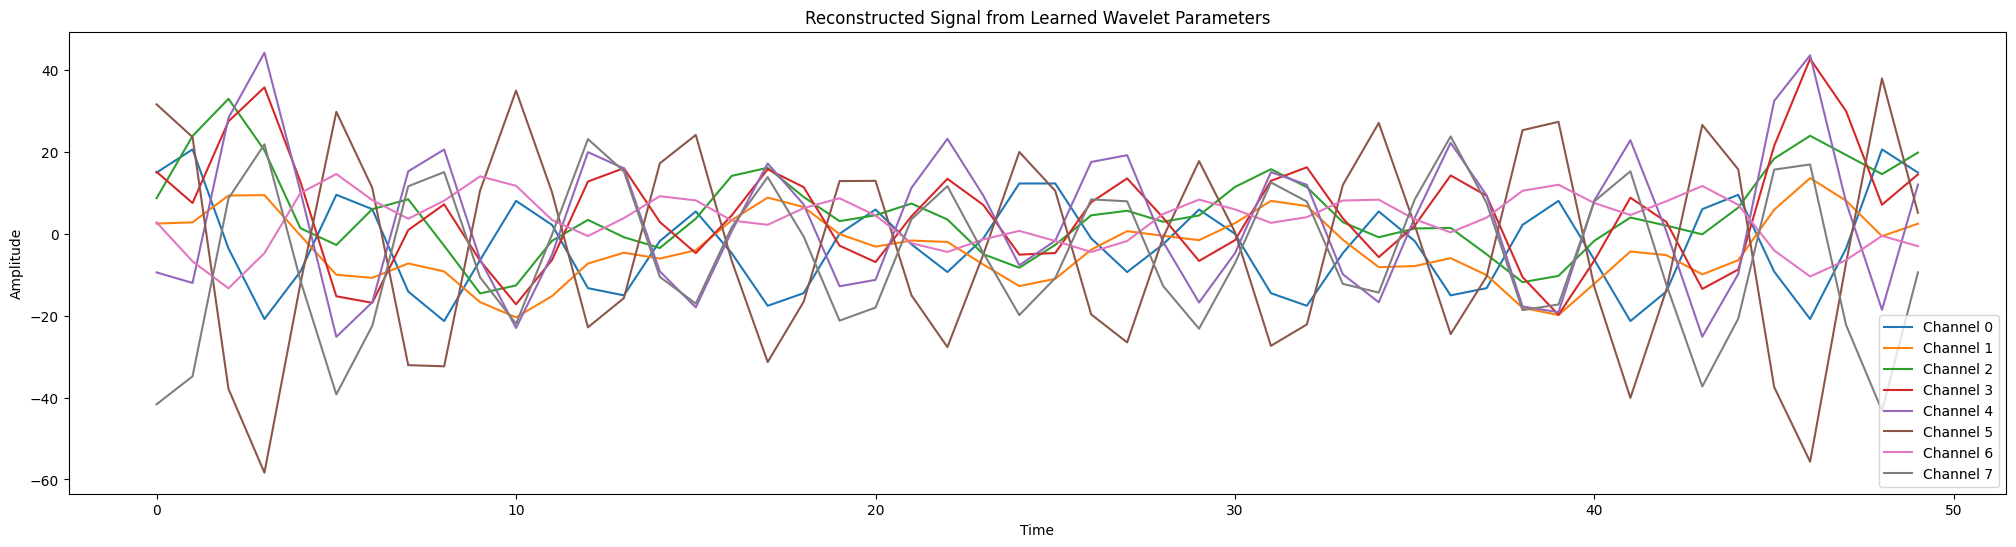

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Load trained parameters (assumed to be saved as .npy files)
# Expected shapes:
# b_trained: (1, 1, 8, 16)
# omega_trained: (1, 1, 1, 16)
# phi_trained: (1, 1, 8, 16)
# beta_trained: (1, 1, 1, 16)
b_trained = np.load("trained_b.npy")
omega_trained = np.load("trained_omega.npy")
phi_trained = np.load("trained_phi.npy")
beta_trained = np.load("trained_beta.npy")

# Define time axis: number of time steps
Nt = 50  # must match the training kernel length
# Reshape t to (Nt, 1, 1, 1) for broadcasting with parameters of shape (1,1,C,K)
t = np.linspace(-Nt//2, Nt//2, Nt).reshape(Nt, 1, 1, 1).astype(np.float32)

# Compute the wavelet components for each filter and each channel:
# This gives a tensor of shape (Nt, 1, C, K)
W_components = (b_trained *
                np.cos(omega_trained * t + phi_trained) *
                np.exp(-beta_trained * t**2))

# Sum over the filter dimension (axis = -1) to combine contributions from all filters
# Resulting shape becomes (Nt, 1, C)
reconstructed = np.sum(W_components, axis=-1)

# Remove the singleton dimension for "1" (if desired), resulting in shape (Nt, C)
reconstructed = np.squeeze(reconstructed, axis=1)

# Plot the reconstructed signal for each channel
plt.figure(figsize=(25, 6))
for c in range(reconstructed.shape[1]):
    plt.plot(np.arange(Nt), reconstructed[:, c], label=f"Channel {c}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Reconstructed Signal from Learned Wavelet Parameters")
plt.legend()
plt.show()


In [11]:
mat = scipy.io.loadmat('toy.mat')
train_data_sample_1 = mat['train'][0]

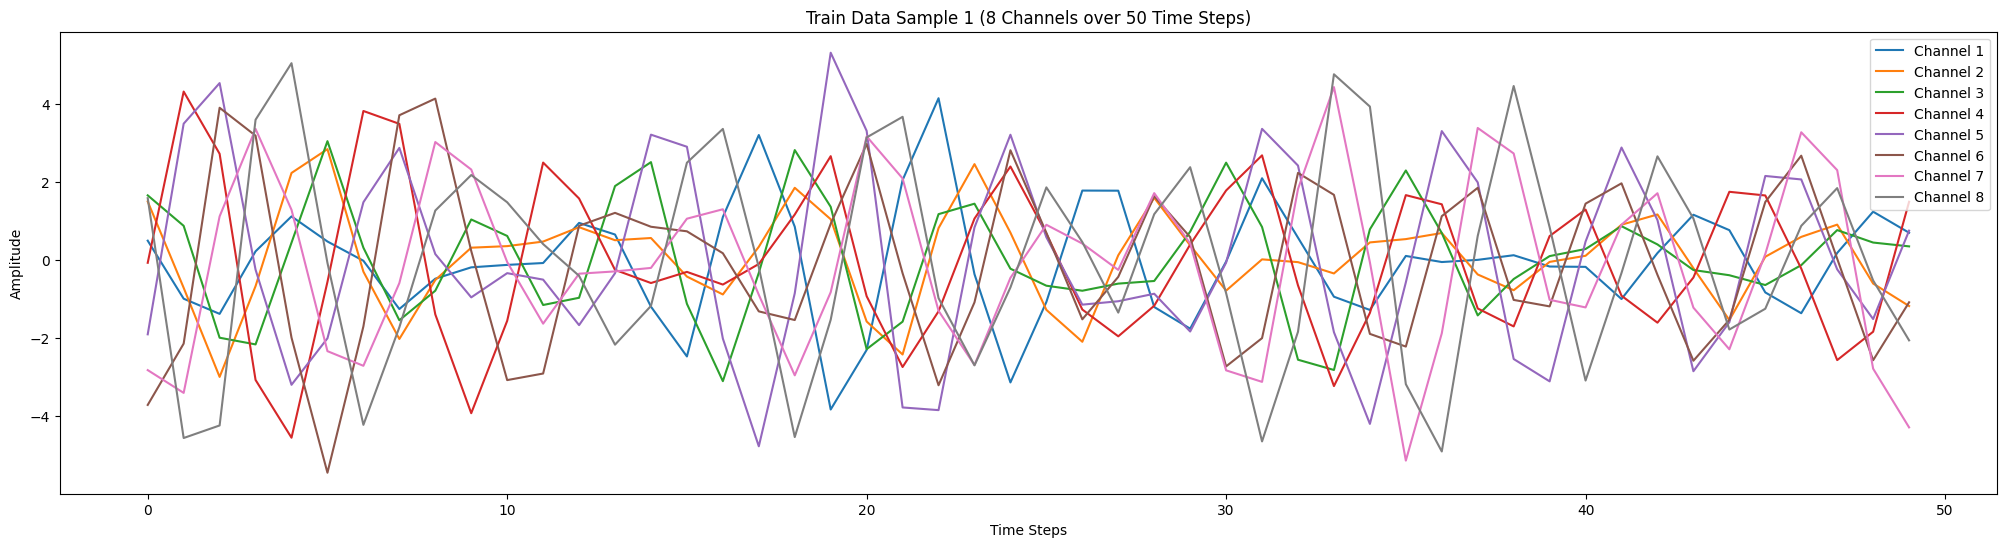

In [17]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Load the data
mat = scipy.io.loadmat('toy.mat')

# Extract the first training sample
train_data_sample_1 = mat['train'][0]  # Shape should be (8, 50)

# Reshape explicitly
train_data_sample_1 = train_data_sample_1.reshape(8, 50)

# Plot each channel over time
plt.figure(figsize=(25, 6))
for i in range(8):
    plt.plot(train_data_sample_1[i], label=f'Channel {i+1}')

plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.title("Train Data Sample 1 (8 Channels over 50 Time Steps)")
plt.legend()
plt.show()

Instructions for updating:
non-resource variables are not supported in the long term


I0000 00:00:1741298289.835554 3498629 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Step 0, MSE: 4.067483, Learning Rate: 0.010000
Step 500, MSE: 0.168926, Learning Rate: 0.009000
Step 1000, MSE: 0.156219, Learning Rate: 0.008100
Step 1500, MSE: 0.132695, Learning Rate: 0.007290
Step 2000, MSE: 0.119355, Learning Rate: 0.006561
Step 2500, MSE: 0.106591, Learning Rate: 0.005905
Step 3000, MSE: 0.103376, Learning Rate: 0.005314
Step 3500, MSE: 0.101735, Learning Rate: 0.004783
Step 4000, MSE: 0.100431, Learning Rate: 0.004305
Step 4500, MSE: 0.099527, Learning Rate: 0.003874


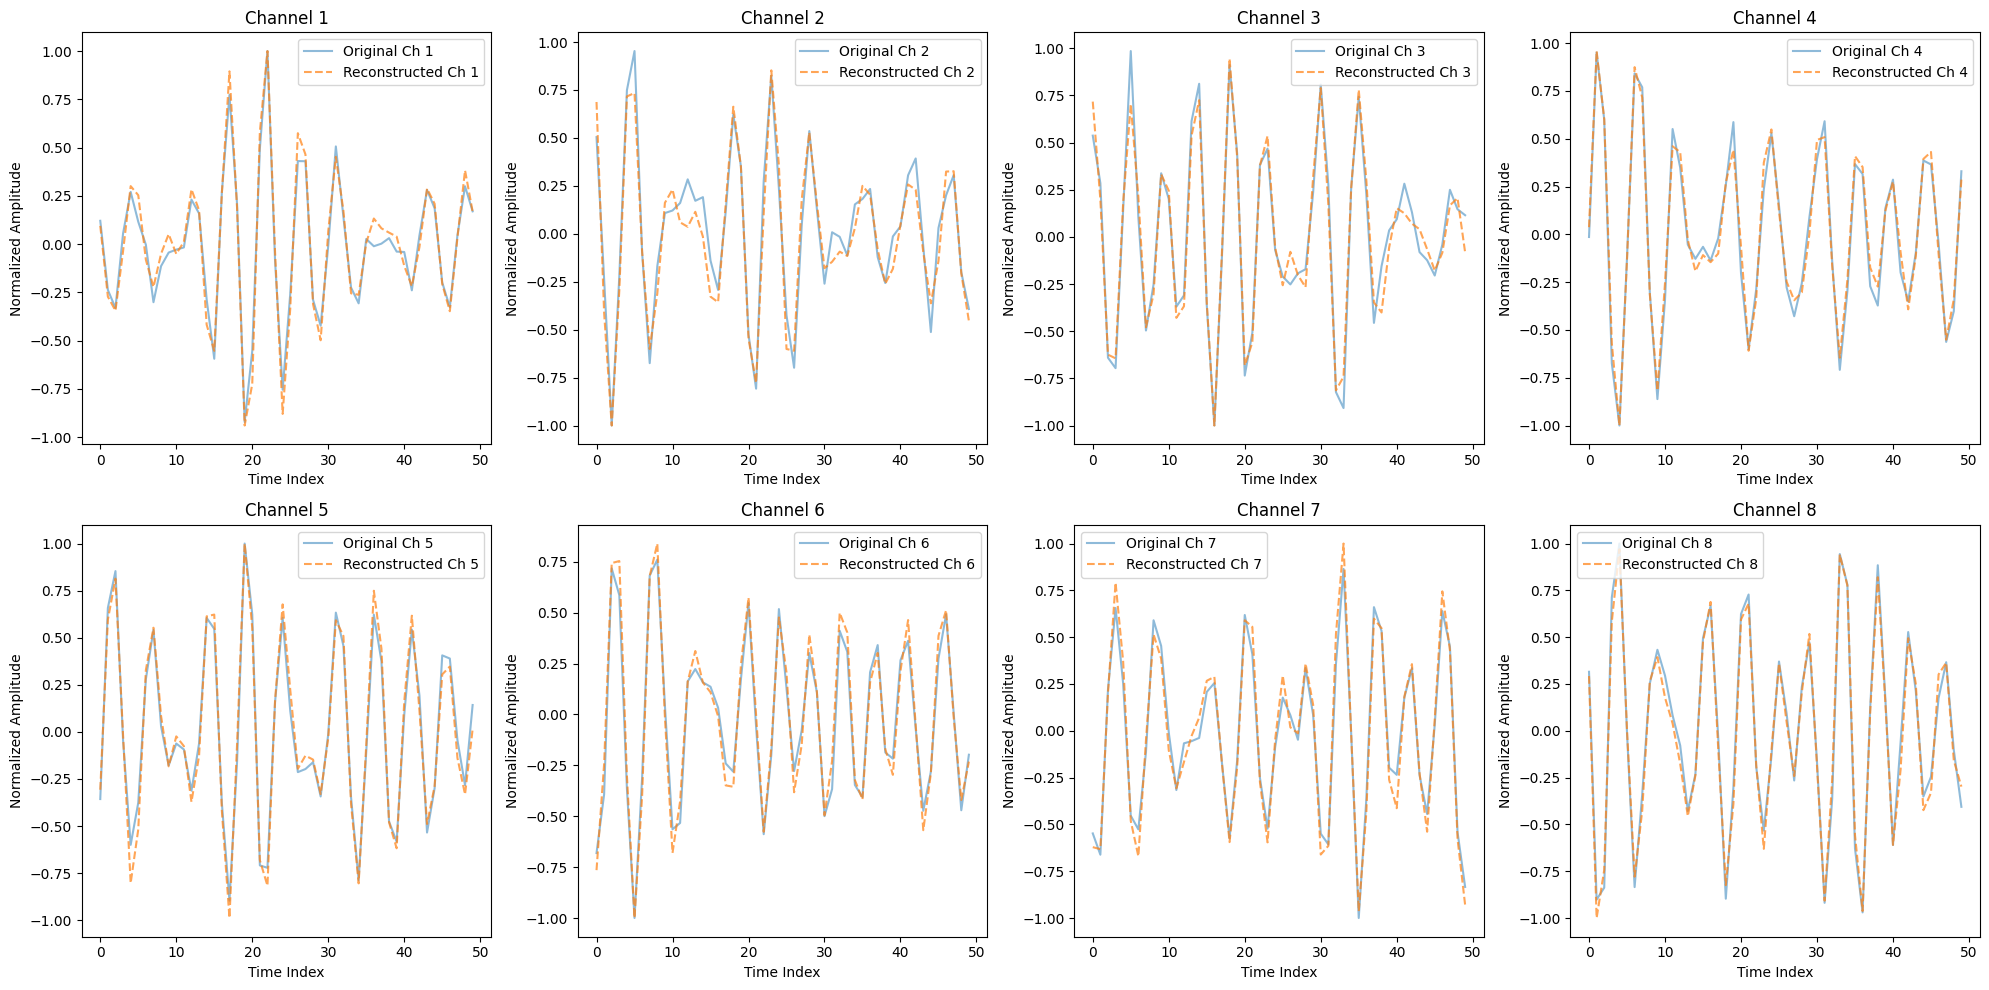

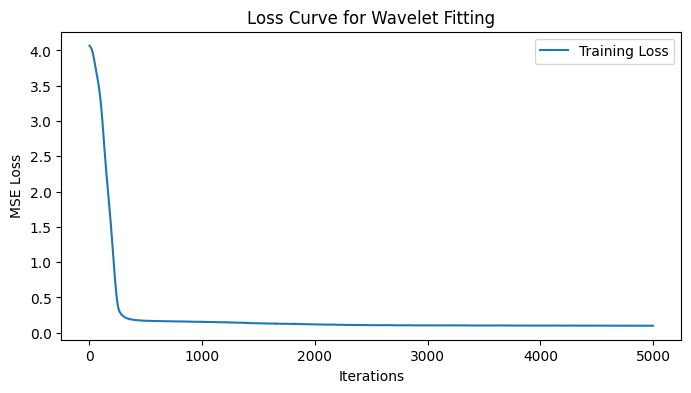

Learned frequencies: [1.1884396 1.298446  1.3984693 1.2460223 1.4344037 1.0011232 1.0212396
 1.1242806]
Learned bandwidths: [0.00016204 0.00013898 0.00928271 0.00048186 0.00157654 0.00021504
 0.00031436 0.02036077]
Learned amplitude shape: (8, 8)
Learned shift shape: (8, 8)


In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

##############################
# 1) Load Your Single Sample
##############################
mat = scipy.io.loadmat('toy.mat')
# Assume 'train' key contains the data; take the first sample
sample = mat['train'][0]  # expected shape (8, 50)
sample = sample.reshape(8, 50).astype(np.float32)

##############################
# 2) Set Seed for Reproducibility
##############################
tf.set_random_seed(42)
np.random.seed(42)

##############################
# 3) Define Graph & Variables
##############################
channels = 8
time_steps = 50
K = 8  # number of wavelet basis functions

# Placeholder for ground truth signal
X_gt = tf.placeholder(tf.float32, shape=(channels, time_steps), name="X_gt")

# Trainable wavelet parameters:
# freq: shape (K,)
freq = tf.Variable(tf.random.uniform([K], minval=0.1, maxval=0.5), name="freq")

# Use log_bandwidth for stability; actual bandwidth = exp(log_bandwidth)
log_bandwidth = tf.Variable(tf.random.uniform([K], minval=-4.0, maxval=-2.0), name="log_bandwidth")
bandwidth = tf.exp(log_bandwidth)

# amplitude and shift: shape (channels, K)
amplitude = tf.Variable(tf.random.uniform([channels, K], minval=-0.05, maxval=0.05), name="amplitude")
shift = tf.Variable(tf.random.uniform([channels, K], minval=-np.pi, maxval=np.pi), name="shift")

# Create a time vector [time_steps], shape (1, 50)
t_vec = tf.cast(tf.range(-time_steps // 2, time_steps // 2), tf.float32)  # e.g. [-25,...,24]
t_vec = tf.reshape(t_vec, [1, time_steps])  # shape: (1, 50)

##############################
# 4) Build Wavelet Reconstruction (Decomposition)
##############################
# Reshape freq and bandwidth to [1, K, 1] for broadcasting over time
freq_reshaped = tf.reshape(freq, [1, K, 1])           # shape: [1, K, 1]
bandwidth_reshaped = tf.reshape(bandwidth, [1, K, 1])   # shape: [1, K, 1]

# Expand amplitude and shift to [channels, K, 1]
amplitude_3d = tf.expand_dims(amplitude, axis=-1)  # shape: [channels, K, 1]
shift_3d = tf.expand_dims(shift, axis=-1)          # shape: [channels, K, 1]

# Reshape t_vec to [1, 1, time_steps] for broadcasting
t_c_k_time = tf.reshape(t_vec, [1, 1, time_steps])  # shape: [1, 1, 50]

# Build the reconstruction:
# For each channel c and each filter k, compute:
# amplitude(c,k) * cos(freq(k)*t + shift(c,k)) * exp(-bandwidth(k)*t^2)
wavelet_components = amplitude_3d * tf.cos(freq_reshaped * t_c_k_time + shift_3d) * \
                     tf.exp(-bandwidth_reshaped * tf.square(t_c_k_time))
# Sum over the filters (axis=1) to get the reconstructed signal: shape [channels, time_steps]
X_reconstructed = tf.reduce_sum(wavelet_components, axis=1)

##############################
# 5) Define Loss (MSE) & Optimizer with Learning Rate Decay
##############################
loss = tf.reduce_mean(tf.square(X_reconstructed - X_gt))
global_step = tf.Variable(0, trainable=False)
# Exponential decay of learning rate every 500 steps
learning_rate = tf.train.exponential_decay(0.01, global_step, decay_steps=500, decay_rate=0.9, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

##############################
# 6) Train Over the Single Sample
##############################
num_steps = 5000  # extended training iterations
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for step in range(num_steps):
        _, loss_val, lr_val = sess.run([train_op, loss, learning_rate], feed_dict={X_gt: sample})
        loss_history.append(loss_val)
        if step % 500 == 0:
            print(f"Step {step}, MSE: {loss_val:.6f}, Learning Rate: {lr_val:.6f}")
    
    # Retrieve final parameters and reconstructed signal
    freq_final, beta_final, amp_final, shift_final = sess.run([freq, bandwidth, amplitude, shift])
    recon_signal = sess.run(X_reconstructed, feed_dict={X_gt: sample})

##############################
# 7) Normalize Ground Truth and Reconstruction for Plotting
##############################
def normalize(signal):
    # Normalize each channel individually
    norm_signal = np.zeros_like(signal)
    for i in range(signal.shape[0]):
        max_val = np.max(np.abs(signal[i]))
        if max_val > 0:
            norm_signal[i] = signal[i] / max_val
        else:
            norm_signal[i] = signal[i]
    return norm_signal

sample_norm = normalize(sample)
recon_norm = normalize(recon_signal)

##############################
# 8) Visualize Results
##############################
# Create subplots: 2 rows x 4 columns
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for i, ax in enumerate(axs.flatten()):
    ax.plot(sample_norm[i], label=f"Original Ch {i+1}", alpha=0.5)
    ax.plot(recon_norm[i], label=f"Reconstructed Ch {i+1}", linestyle='--', alpha=0.7)
    ax.set_title(f"Channel {i+1}")
    ax.set_xlabel("Time Index")
    ax.set_ylabel("Normalized Amplitude")
    ax.legend()
plt.tight_layout()
plt.show()

# Plot loss over iterations
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Loss Curve for Wavelet Fitting")
plt.legend()
plt.show()

print("Learned frequencies:", freq_final)
print("Learned bandwidths:", beta_final)
print("Learned amplitude shape:", amp_final.shape)
print("Learned shift shape:", shift_final.shape)

Step 0, MSE: 0.000002, Learning Rate: 0.010000
Step 500, MSE: 0.000000, Learning Rate: 0.009000
Step 1000, MSE: 0.000000, Learning Rate: 0.008100
Step 1500, MSE: 0.000000, Learning Rate: 0.007290
Step 2000, MSE: 0.000000, Learning Rate: 0.006561
Step 2500, MSE: 0.000000, Learning Rate: 0.005905
Step 3000, MSE: 0.000000, Learning Rate: 0.005314
Step 3500, MSE: 0.000000, Learning Rate: 0.004783
Step 4000, MSE: 0.000000, Learning Rate: 0.004305
Step 4500, MSE: 0.000000, Learning Rate: 0.003874


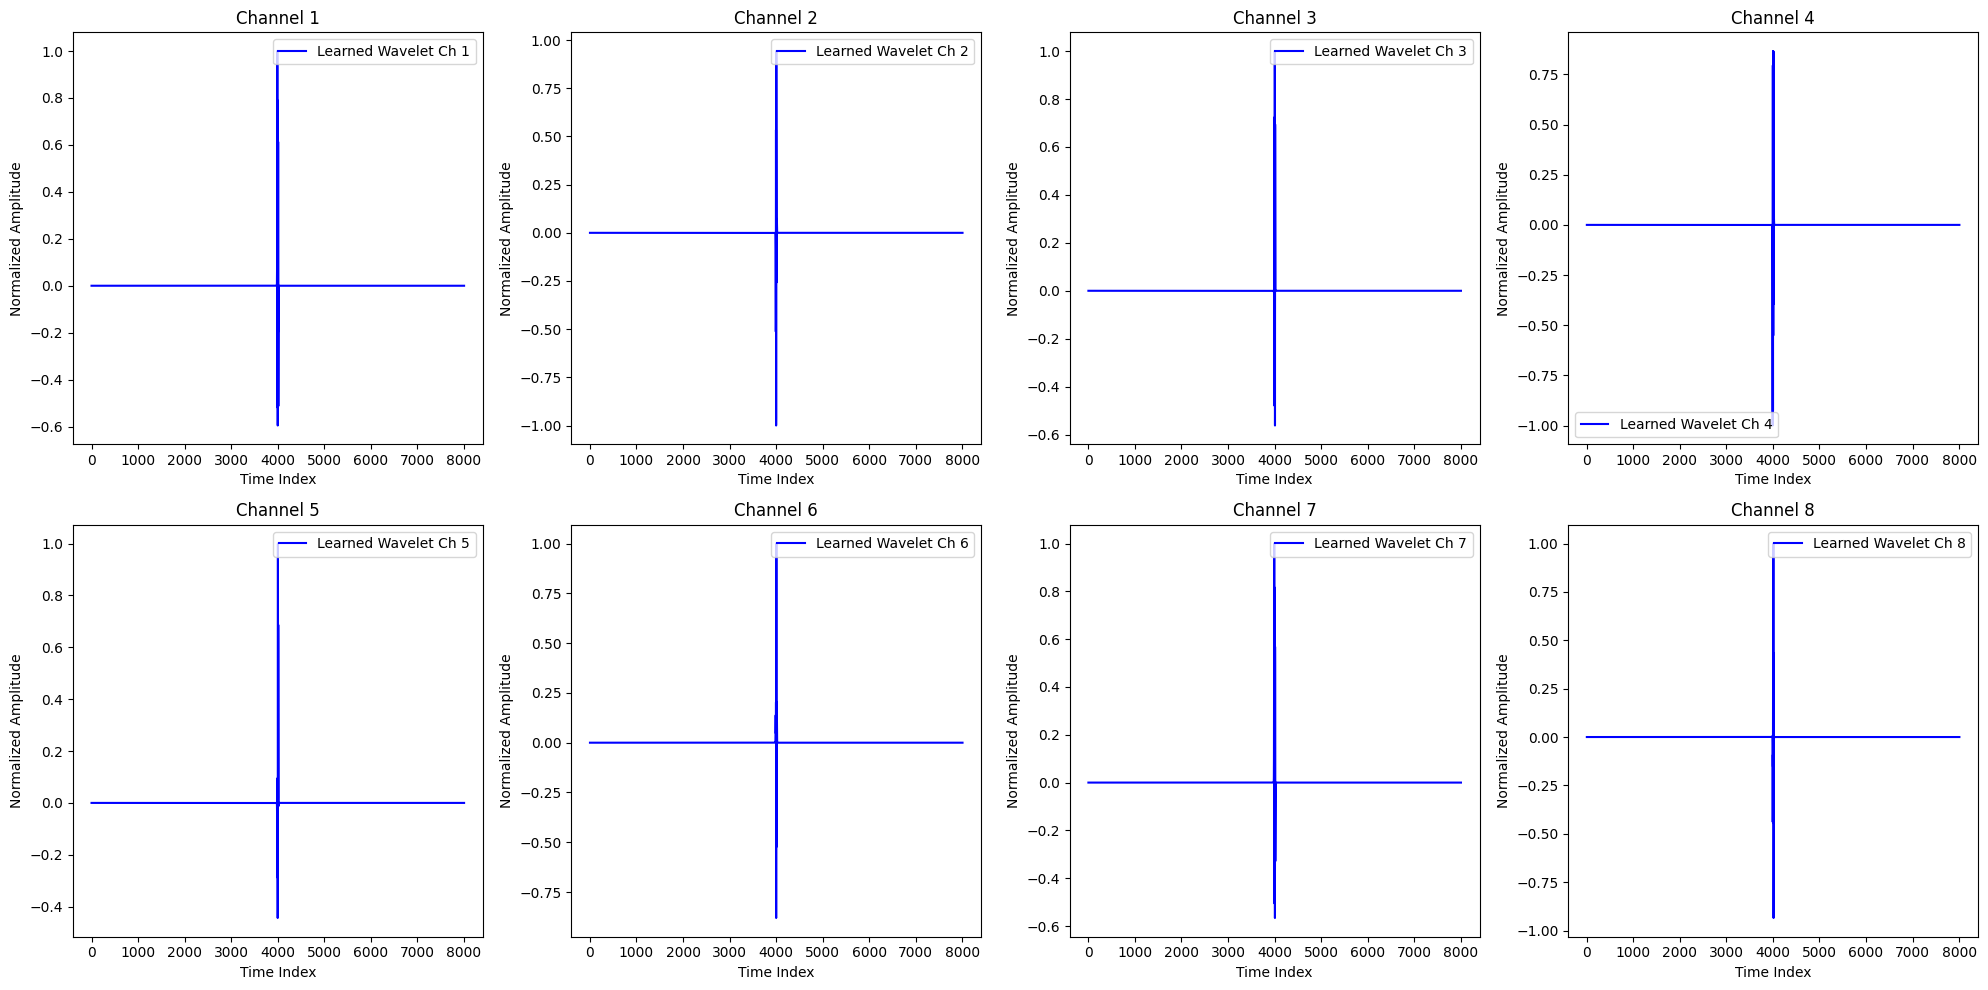

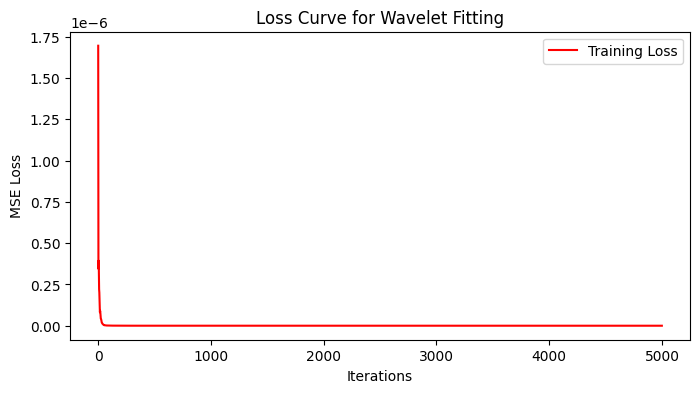

Learned frequencies: [0.11212265 0.32158968 0.04841556 0.01953231 0.01734228 0.10137896
 0.23869959 0.0687576 ]
Learned bandwidths: [0.02440258 0.0473927  0.03465584 0.08002821 0.09355342 0.02889107
 0.05557867 0.03576989]
Learned amplitude shape: (59, 8)
Learned shift shape: (59, 8)


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

##############################
# 1) Load Your Single Sample
##############################
oca_mat = scipy.io.loadmat('OCA_data.mat')
sample = oca_mat['X']
# [:5,:50] # shape: 59, 8008

##############################
# 2) Set Seed for Reproducibility
##############################
tf.set_random_seed(42)
np.random.seed(42)

##############################
# 3) Define Graph & Variables
##############################
channels = 59
time_steps = 8008
K = 2  # number of wavelet basis functions

# Placeholder for ground truth signal (used only for training loss)
X_gt = tf.placeholder(tf.float32, shape=(channels, time_steps), name="X_gt")

# Trainable wavelet parameters:
# Frequency: shape (K,)
freq = tf.Variable(tf.random.uniform([K], minval=0.1, maxval=0.5), name="freq")

# Use log_bandwidth for stability; actual bandwidth = exp(log_bandwidth)
log_bandwidth = tf.Variable(tf.random.uniform([K], minval=-4.0, maxval=-2.0), name="log_bandwidth")
bandwidth = tf.exp(log_bandwidth)

# Amplitude and shift: shape (channels, K)
amplitude = tf.Variable(tf.random.uniform([channels, K], minval=-0.05, maxval=0.05), name="amplitude")
shift = tf.Variable(tf.random.uniform([channels, K], minval=-np.pi, maxval=np.pi), name="shift")

# Create a time vector [time_steps], shape (1, 50)
t_vec = tf.cast(tf.range(-time_steps // 2, time_steps // 2), tf.float32)  # e.g. [-25,...,24]
t_vec = tf.reshape(t_vec, [1, time_steps])  # shape: (1, 50)

##############################
# 4) Build Wavelet Reconstruction (Decomposition)
##############################
# Reshape freq and bandwidth to [1, K, 1] for broadcasting over time
freq_reshaped = tf.reshape(freq, [1, K, 1])
bandwidth_reshaped = tf.reshape(bandwidth, [1, K, 1])

# Expand amplitude and shift to [channels, K, 1]
amplitude_3d = tf.expand_dims(amplitude, axis=-1)  # shape: (channels, K, 1)
shift_3d = tf.expand_dims(shift, axis=-1)          # shape: (channels, K, 1)

# Reshape t_vec to [1, 1, time_steps] for broadcasting
t_c_k_time = tf.reshape(t_vec, [1, 1, time_steps])

# Compute the individual wavelet components:
# wavelet(c,k,t) = amplitude(c,k) * cos(freq(k)*t + shift(c,k)) * exp(-bandwidth(k)*t^2)
wavelet_components = amplitude_3d * tf.cos(freq_reshaped * t_c_k_time + shift_3d) * \
                     tf.exp(-bandwidth_reshaped * tf.square(t_c_k_time))

# The final learned wavelet for each channel is the sum over the K components.
X_reconstructed = tf.reduce_sum(wavelet_components, axis=1)

##############################
# 5) Define Loss (MSE) & Optimizer with Learning Rate Decay
##############################
loss = tf.reduce_mean(tf.square(X_reconstructed - X_gt))
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.01, global_step, decay_steps=500, decay_rate=0.9, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

##############################
# 6) Train Over the Single Sample
##############################
num_steps = 5000  # extended training iterations
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for step in range(num_steps):
        _, loss_val, lr_val = sess.run([train_op, loss, learning_rate], feed_dict={X_gt: sample})
        loss_history.append(loss_val)
        if step % 500 == 0:
            print(f"Step {step}, MSE: {loss_val:.6f}, Learning Rate: {lr_val:.6f}")
    
    # Retrieve final parameters and compute the learned wavelet
    freq_final, beta_final, amp_final, shift_final = sess.run([freq, bandwidth, amplitude, shift])
    recon_signal = sess.run(X_reconstructed, feed_dict={X_gt: sample})

##############################
# 7) Normalize Learned Wavelet for Plotting
##############################
def normalize(signal):
    norm_signal = np.zeros_like(signal)
    for i in range(signal.shape[0]):
        max_val = np.max(np.abs(signal[i]))
        norm_signal[i] = signal[i] / max_val if max_val > 0 else signal[i]
    return norm_signal

# Normalize the learned wavelet for each channel
recon_norm = normalize(recon_signal)

##############################
# 8) Visualize the Learned Wavelet
##############################
# Plot only the learned wavelet for each channel.
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for i, ax in enumerate(axs.flatten()):
    if i < channels:
        ax.plot(recon_norm[i], label=f"Learned Wavelet Ch {i+1}", color='blue')
        ax.set_title(f"Channel {i+1}")
        ax.set_xlabel("Time Index")
        ax.set_ylabel("Normalized Amplitude")
        ax.legend()
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()

# Optionally, plot the loss curve for reference
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Training Loss", color='red')
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Loss Curve for Wavelet Fitting")
plt.legend()
plt.show()

print("Learned frequencies:", freq_final)
print("Learned bandwidths:", beta_final)
print("Learned amplitude shape:", amp_final.shape)
print("Learned shift shape:", shift_final.shape)

Step 0, MSE: 0.434875, Learning Rate: 0.010000
Step 500, MSE: 0.287242, Learning Rate: 0.009000
Step 1000, MSE: 0.287227, Learning Rate: 0.008100
Step 1500, MSE: 0.287228, Learning Rate: 0.007290
Step 2000, MSE: 0.287227, Learning Rate: 0.006561
Step 2500, MSE: 0.287227, Learning Rate: 0.005905
Step 3000, MSE: 0.287227, Learning Rate: 0.005314
Step 3500, MSE: 0.287227, Learning Rate: 0.004783
Step 4000, MSE: 0.287227, Learning Rate: 0.004305
Step 4500, MSE: 0.287227, Learning Rate: 0.003874
Step 5000, MSE: 0.287242, Learning Rate: 0.003487
Step 5500, MSE: 0.287227, Learning Rate: 0.003138
Step 6000, MSE: 0.287227, Learning Rate: 0.002824
Step 6500, MSE: 0.287227, Learning Rate: 0.002542
Step 7000, MSE: 0.287227, Learning Rate: 0.002288
Step 7500, MSE: 0.287227, Learning Rate: 0.002059
Step 8000, MSE: 0.287227, Learning Rate: 0.001853
Step 8500, MSE: 0.287230, Learning Rate: 0.001668
Step 9000, MSE: 0.287227, Learning Rate: 0.001501
Step 9500, MSE: 0.287227, Learning Rate: 0.001351


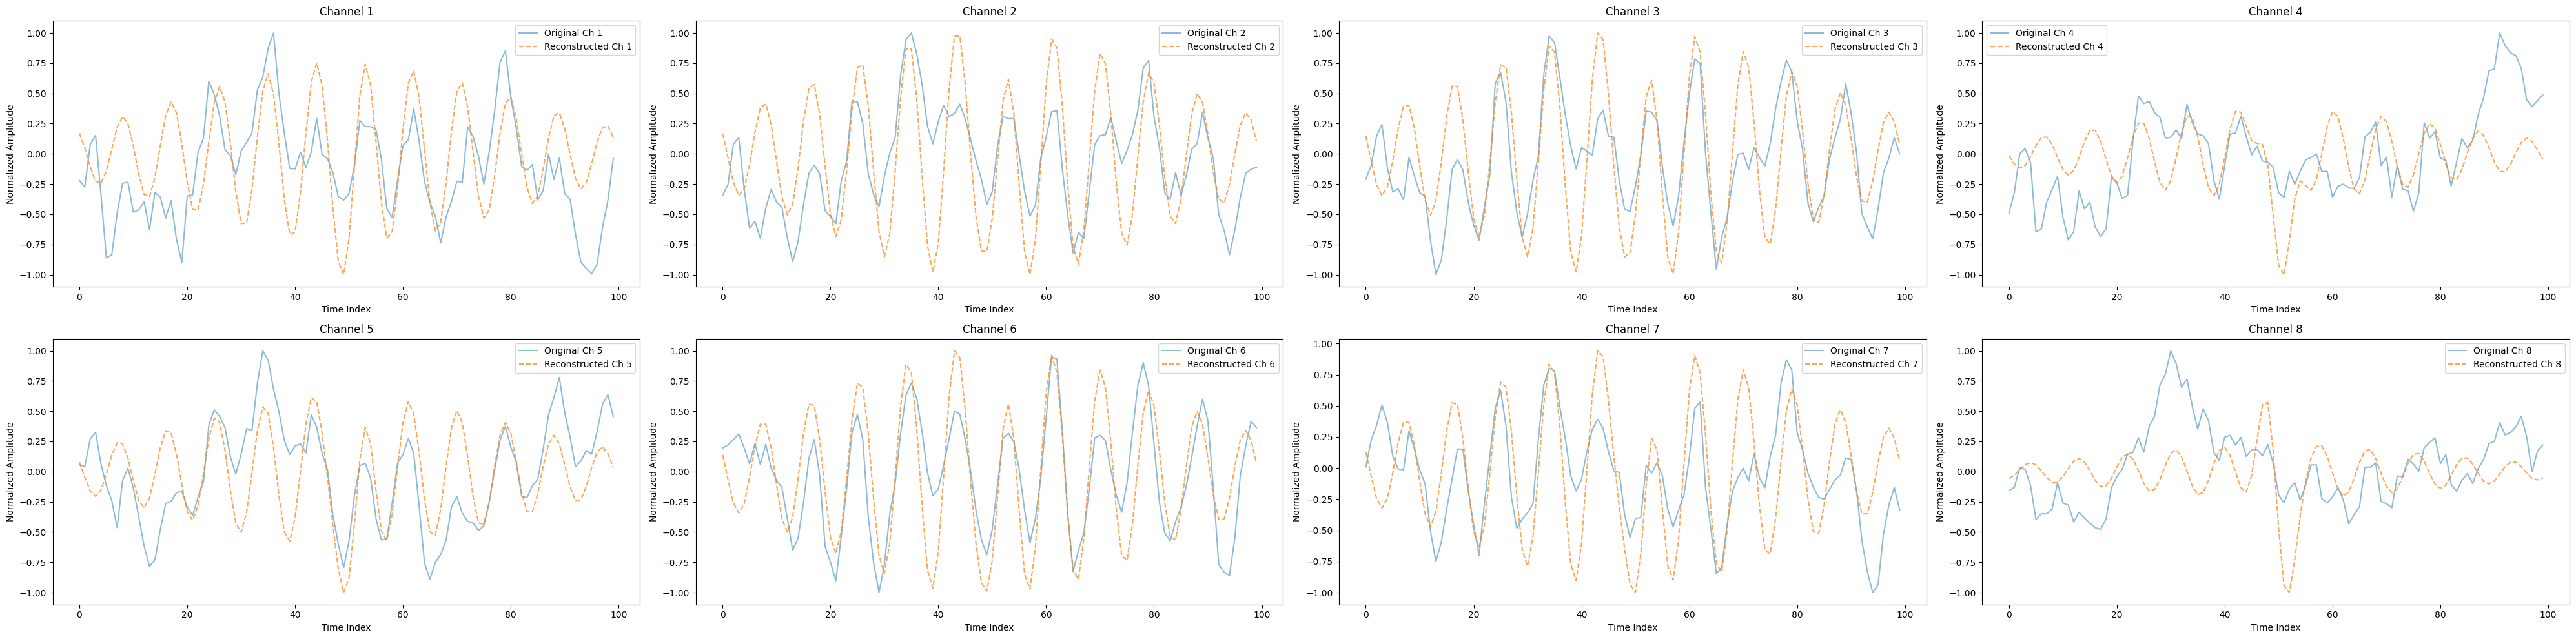

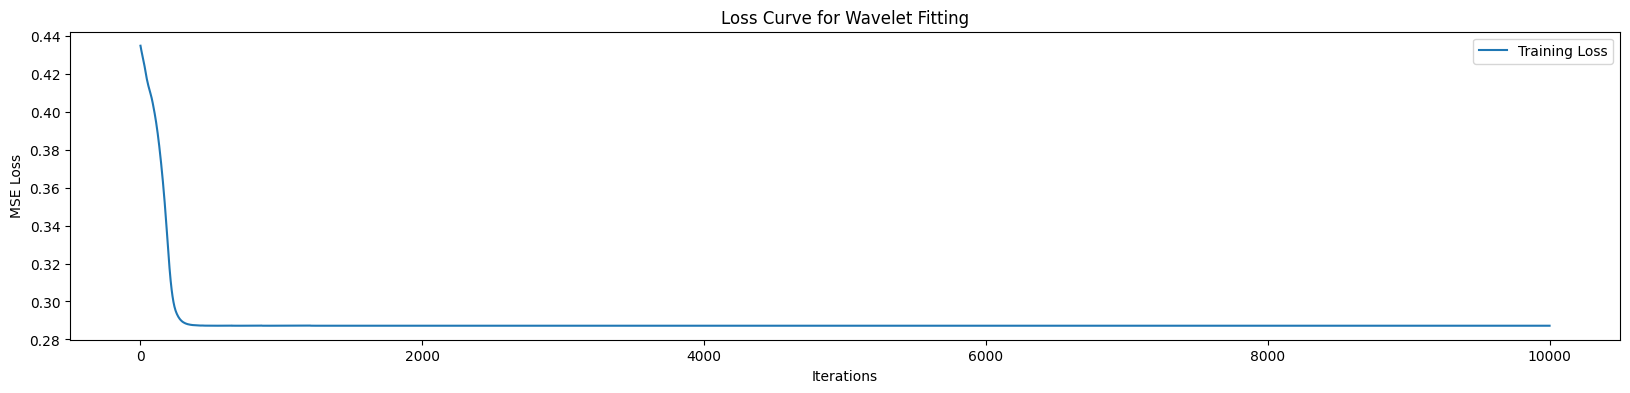

Learned frequencies: [0.5038349  0.70087117]
Learned bandwidths: [0.07804781 0.00050067]
Learned amplitude shape: (8, 2)
Learned shift shape: (8, 2)


In [23]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

##############################
# 1) Load Your Single Sample
##############################
oca_mat = scipy.io.loadmat('OCA_data.mat')
sample = oca_mat['X'][:8,:100] * scale # shape: 59, 8008

##############################
# 2) Set Seed for Reproducibility
##############################
tf.set_random_seed(42)
np.random.seed(42)

##############################
# 3) Define Graph & Variables
##############################
channels = 8
time_steps = 100
K = 2  # number of wavelet basis functions

# Placeholder for ground truth signal
X_gt = tf.placeholder(tf.float32, shape=(channels, time_steps), name="X_gt")

# Trainable wavelet parameters:
# freq: shape (K,)
freq = tf.Variable(tf.random.uniform([K], minval=0.1, maxval=0.5), name="freq")

# Use log_bandwidth for stability; actual bandwidth = exp(log_bandwidth)
log_bandwidth = tf.Variable(tf.random.uniform([K], minval=-4.0, maxval=-2.0), name="log_bandwidth")
bandwidth = tf.exp(log_bandwidth)

# amplitude and shift: shape (channels, K)
amplitude = tf.Variable(tf.random.uniform([channels, K], minval=-0.05, maxval=0.05), name="amplitude")
shift = tf.Variable(tf.random.uniform([channels, K], minval=-np.pi, maxval=np.pi), name="shift")

# Create a time vector [time_steps], shape (1, 50)
t_vec = tf.cast(tf.range(-time_steps // 2, time_steps // 2), tf.float32)  # e.g. [-25,...,24]
t_vec = tf.reshape(t_vec, [1, time_steps])  # shape: (1, 50)

##############################
# 4) Build Wavelet Reconstruction (Decomposition)
##############################
# Reshape freq and bandwidth to [1, K, 1] for broadcasting over time
freq_reshaped = tf.reshape(freq, [1, K, 1])           # shape: [1, K, 1]
bandwidth_reshaped = tf.reshape(bandwidth, [1, K, 1])   # shape: [1, K, 1]

# Expand amplitude and shift to [channels, K, 1]
amplitude_3d = tf.expand_dims(amplitude, axis=-1)  # shape: [channels, K, 1]
shift_3d = tf.expand_dims(shift, axis=-1)          # shape: [channels, K, 1]

# Reshape t_vec to [1, 1, time_steps] for broadcasting
t_c_k_time = tf.reshape(t_vec, [1, 1, time_steps])  # shape: [1, 1, 50]

# Build the reconstruction:
# For each channel c and each filter k, compute:
# amplitude(c,k) * cos(freq(k)*t + shift(c,k)) * exp(-bandwidth(k)*t^2)
wavelet_components = amplitude_3d * tf.cos(freq_reshaped * t_c_k_time + shift_3d) * \
                     tf.exp(-bandwidth_reshaped * tf.square(t_c_k_time))
# Sum over the filters (axis=1) to get the reconstructed signal: shape [channels, time_steps]
X_reconstructed = tf.reduce_sum(wavelet_components, axis=1)

##############################
# 5) Define Loss (MSE) & Optimizer with Learning Rate Decay
##############################
loss = tf.reduce_mean(tf.square(X_reconstructed - X_gt))
global_step = tf.Variable(0, trainable=False)
# Exponential decay of learning rate every 500 steps
learning_rate = tf.train.exponential_decay(0.01, global_step, decay_steps=500, decay_rate=0.9, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

##############################
# 6) Train Over the Single Sample
##############################
num_steps = 10000  # extended training iterations
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_history = []
    for step in range(num_steps):
        _, loss_val, lr_val = sess.run([train_op, loss, learning_rate], feed_dict={X_gt: sample})
        loss_history.append(loss_val)
        if step % 500 == 0:
            print(f"Step {step}, MSE: {loss_val:.6f}, Learning Rate: {lr_val:.6f}")
    
    # Retrieve final parameters and reconstructed signal
    freq_final, beta_final, amp_final, shift_final = sess.run([freq, bandwidth, amplitude, shift])
    recon_signal = sess.run(X_reconstructed, feed_dict={X_gt: sample})

##############################
# 7) Normalize Ground Truth and Reconstruction for Plotting
##############################
def normalize(signal):
    # Normalize each channel individually
    norm_signal = np.zeros_like(signal)
    for i in range(signal.shape[0]):
        max_val = np.max(np.abs(signal[i]))
        if max_val > 0:
            norm_signal[i] = signal[i] / max_val
        else:
            norm_signal[i] = signal[i]
    return norm_signal

sample_norm = normalize(sample)
recon_norm = normalize(recon_signal)

##############################
# 8) Visualize Results
##############################
# Create subplots: 2 rows x 4 columns
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(40, 10))
for i, ax in enumerate(axs.flatten()):
    ax.plot(sample_norm[i], label=f"Original Ch {i+1}", alpha=0.5)
    ax.plot(recon_norm[i], label=f"Reconstructed Ch {i+1}", linestyle='--', alpha=0.7)
    ax.set_title(f"Channel {i+1}")
    ax.set_xlabel("Time Index")
    ax.set_ylabel("Normalized Amplitude")
    ax.legend()
plt.tight_layout()
plt.show()

# Plot loss over iterations
plt.figure(figsize=(20, 4))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("MSE Loss")
plt.title("Loss Curve for Wavelet Fitting")
plt.legend()
plt.show()

print("Learned frequencies:", freq_final)
print("Learned bandwidths:", beta_final)
print("Learned amplitude shape:", amp_final.shape)
print("Learned shift shape:", shift_final.shape)

In [ ]:
sum(freq_final)

np.float32(6.3068657)

In [17]:
f

7.463400688

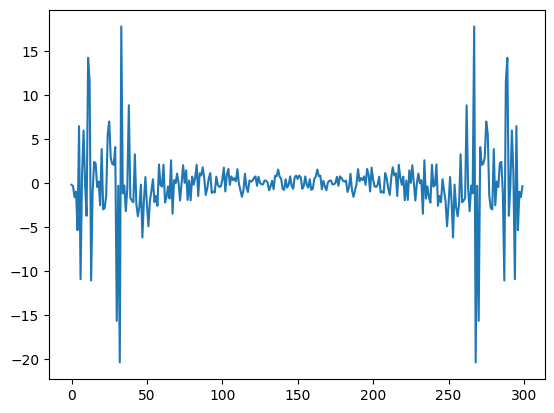

In [10]:
plt.plot(np.fft.fft(sample_norm[0]))

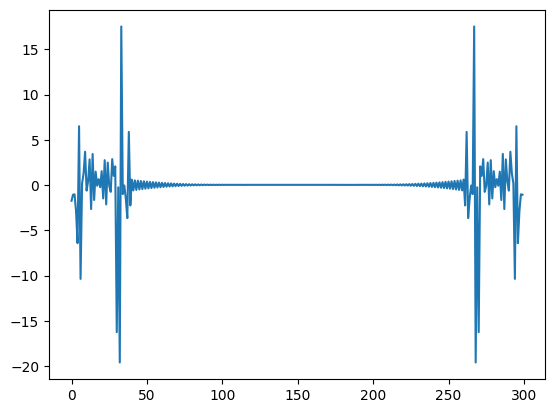

In [11]:
plt.plot(np.fft.fft(recon_norm[0]))

In [ ]:
print("Learned frequencies:", freq_final)
print("Learned bandwidths:", beta_final)
print("Learned amplitude shape:", amp_final.shape)
print("Learned shift shape:", shift_final.shape)

In [ ]:
time_steps = 50
t_vec = tf.cast(tf.range(-time_steps // 2, time_steps // 2), tf.float32)  # e.g. [-25,...,24]
t_vec = tf.reshape(t_vec, [1, time_steps])  # shape: (1, 50)
t_c_k_time = tf.reshape(t_vec, [1, 1, time_steps])  # shape: [1, 1, 50]

In [ ]:
wavelet_components = amplitude_3d * tf.cos(freq_final * t_c_k_time + shift_3d) * \
                     tf.exp(-bandwidth_reshaped * tf.square(t_c_k_time))